# Apache Spark Partitioning

Partitioning is the process of dividing a large dataset into smaller, more manageable chunks, known as partitions. In Spark, each partition is a logical chunk of a large distributed data frame or RDD (Resilient Distributed Dataset).

$$
\text{Number of Partitions} = \frac{\text{Size of Data}}{\text{Size of each Partition}}
$$

## Importance of Partitioning

- **Load Balancing:** Proper partitioning ensures that data is evenly distributed across the cluster.
  
- **Optimized Data Shuffling:** Well-partitioned data minimizes data shuffling during operations like $join$, $group by$, etc.
  
- **Parallelism:** More partitions allow for more concurrency, but too many partitions can also cause overhead.

## Types of Partitioning in Spark

### 1. Hash Partitioning

In Hash Partitioning, Spark will create the partitions based on the hash value of the key. For example, if you have 1000 keys and you want to create 10 partitions, then Spark will create 10 partitions based on the hash value of the key. The hash value of the key will be calculated by using the following formula:

$$
\text{Partition} = \text{hash}(key) \mod \text{numPartitions}
$$

### 2. Range Partitioning

In Range Partitioning, Spark will create the partitions based on the range of the key. For example, if you have 1000 keys and you want to create 10 partitions, then Spark will create 10 partitions based on the range of the key. The range of the key will be calculated by using the following formula:


In range partitioning, data is partitioned based on a range of key values. All records with keys within a specific range fall into the same partition.

$$
\text{Partition} = (Max Key - Min Key) / numPartitions
$$

### 3. Custom Partitioning

You can also implement custom partitioning logic based on the specific requirements of your application.

## Best Practices

- Choose the right type of partitioning based on the operations you are going to perform.
  
- Try to minimize data shuffling.
  
- Avoid having too few or too many partitions.

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

In [2]:
# Create RDD
rdd = sc.parallelize([2, 2, 2, 2, 2, 2, 2, 2], 8)
rdd.getNumPartitions()

8

# RDD Repartition

In [4]:
# Repartition the RDD
rdd=rdd.repartition(8)
rdd.getNumPartitions()

8

In [5]:
print("All data\n",rdd.collect())
print("partitions\n",rdd.glom().collect())

All data
 [2, 2, 2, 2, 2, 2, 2, 2]
partitions
 [[2], [], [2], [2], [2], [], [2], [2, 2, 2]]


In [6]:
# Create a threeAggregate that calculate the sum of the elements and counts the elements
a =  rdd.treeAggregate((0,0), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)

(16, 8)


In [7]:
a =  rdd.repartition(1)\
    .treeAggregate((1, 1), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)

(17, 9)


In [8]:
a =  rdd.repartition(4)\
    .treeAggregate((1, 1), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)

(20, 12)


In [9]:
a =  rdd.repartition(8)\
.treeAggregate((1, 1), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)


(24, 16)


# RDD coalesce()
Spark **repartition()** is used to increase or decrease the RDD, DataFrame, Dataset partitions whereas the **coalesce()** is used to only decrease the number of partitions in an efficient way.

In [9]:
rdd =  rdd.repartition(8)
a =  rdd.coalesce(4)\
    .treeAggregate((0,0),lambda x,y:(x[0]+y,x[1]+1),lambda x,y:(x[0]+y[0],x[1]+y[1]),depth=20)

print(a)


(16, 8)


# AggregateByKey Example

**Partiton by key using valid initialisation (0,0)**

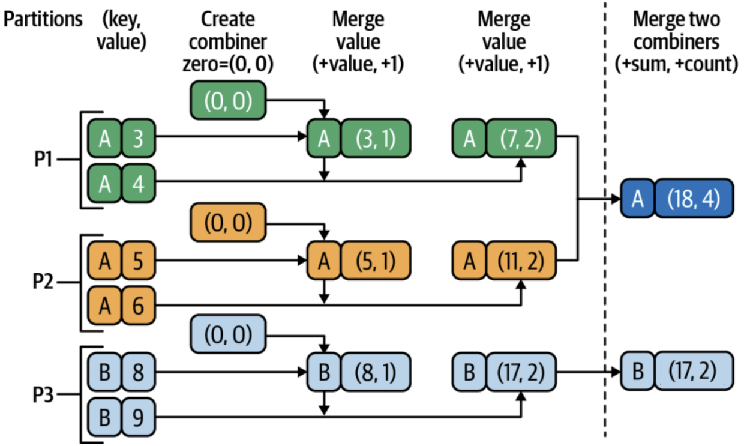

**Picture form the book Data Algorithms with Spark, by Mahmoud Parsian, O'Reilly Media, 2022

In [10]:
ratings = sc.parallelize([("A",3),("A",4),("A",5),("A",6),("B",8),("B",9),], 3)
print("partitions\n",ratings.glom().collect())
sum_count = ratings.aggregateByKey((0, 0),
                (lambda C, V: (C[0]+V, C[1]+1)),
                (lambda C1, C2: (C1[0]+C2[0], C1[1]+C2[1]))
            )
print("result\n",sum_count.collect())

partitions
 [[('A', 3), ('A', 4)], [('A', 5), ('A', 6)], [('B', 8), ('B', 9)]]
result
 [('B', (17, 2)), ('A', (18, 4))]


**Partitioning by key but using invalid initialisation (10,20)**

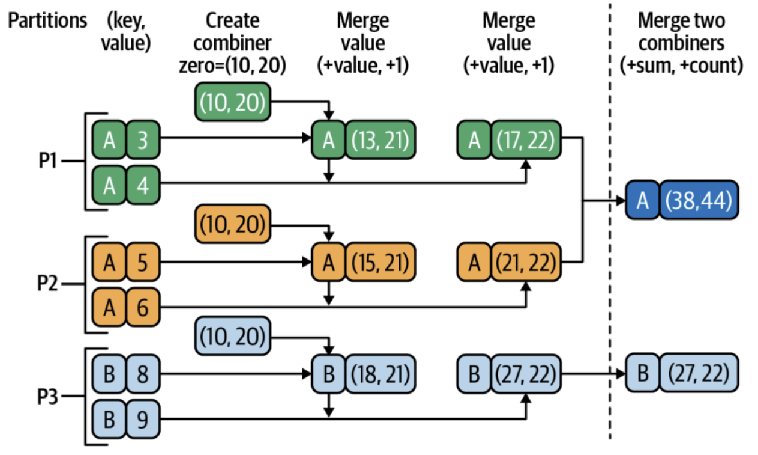

**Picture form the book Data Algorithms with Spark, by Mahmoud Parsian, O'Reilly Media, 2022

In [11]:
# Create a RDD with 3 partitions
ratings = sc.parallelize([("A",3),("A",4),("A",5),("A",6),("B",8),("B",9),],3)
print("partitions\n",ratings.glom().collect())
sum_count = ratings.aggregateByKey((10, 20),
                (lambda C, V: (C[0]+V, C[1]+1)),
                (lambda C1, C2: (C1[0]+C2[0], C1[1]+C2[1]))
            )
print("result\n",sum_count.collect())


partitions
 [[('A', 3), ('A', 4)], [('A', 5), ('A', 6)], [('B', 8), ('B', 9)]]
result
 [('B', (27, 22)), ('A', (38, 44))]


# Spark DataFrame repartition()
Unlike RDD, you can’t specify the partition/parallelism while creating DataFrame. 

Spark DataFrame repartition() method is used to increase or decrease the partitions.


In [12]:
b = [('Chris', 'Berliner', 5),('Paul', 'Amstel', 6), ('Peter', 'Bud Light', 9), ('John', 'Corona Extra', 6)]
df = spark.createDataFrame(b, ['drinker', 'beer', 'score'])
print(df.rdd.glom().collect())

[[Row(drinker='Chris', beer='Berliner', score=5), Row(drinker='Paul', beer='Amstel', score=6), Row(drinker='Peter', beer='Bud Light', score=9), Row(drinker='John', beer='Corona Extra', score=6)]]


In [13]:
df2 = df.repartition(4)
print(df2.rdd.glom().collect())

[[Row(drinker='Peter', beer='Bud Light', score=9)], [Row(drinker='Paul', beer='Amstel', score=6)], [Row(drinker='John', beer='Corona Extra', score=6)], [Row(drinker='Chris', beer='Berliner', score=5)]]


# Spark DataFrame partitioning

Spark DataFrame partitioning is the process of dividing a large DataFrame into smaller DataFrame based on the column value or expression.

## Hash Partitioning Example
In PySpark, the repartition() method can achieve hash partitioning for a DataFrame based on one or multiple column(s).

In [36]:
data = [("Alice", "IT"), ("Bob", "HR"), ("Tom", "HR"),("Catherine", "Finance"), ("Harry", "Finance"), ("Alvin", "IT"), ("Ana", "HR"), ("Bea", "Finance")]
columns = ["Name", "Department"]

df = spark.createDataFrame(data, columns)

# Hash partitioning based on the 'Department' column
hash_partitioned_df = df.repartition(3, "Department")

# show the partitions
def show_partitions_in_df(partitioned_df):
    num_partitions = partitioned_df.rdd.getNumPartitions()
    print(f"Total Partitions: {num_partitions}")
    for idx, part in enumerate(partitioned_df.rdd.glom().collect()):
        print(f"Partition {idx}: {part}")

show_partitions_in_df(hash_partitioned_df)


Total Partitions: 3
Partition 0: [Row(Name='Alice', Department='IT'), Row(Name='Alvin', Department='IT')]
Partition 1: [Row(Name='Bob', Department='HR'), Row(Name='Tom', Department='HR'), Row(Name='Ana', Department='HR')]
Partition 2: [Row(Name='Catherine', Department='Finance'), Row(Name='Harry', Department='Finance'), Row(Name='Bea', Department='Finance')]


## Range Partitioning Example
PySpark DataFrames support range partitioning using the repartitionByRange() method.

In [23]:
# Create a DataFrame
data = [("Alice", 34), ("Bob", 45), ("Catherine", 29), ("Daniel", 28), ("Ella", 45), ("Frank", 10), ("George", 32), ("Harry", 19), ("Irene", 27), ("Jack", 32)]
columns = ["Name", "Age"]
df = spark.createDataFrame(data, columns)

# Perform range partitioning based on the 'Age' column
range_partitioned_df = df.repartitionByRange(3, "Age")

# show the partitions
def show_partitions_in_df(partitioned_df):
    num_partitions = partitioned_df.rdd.getNumPartitions()
    print(f"Total Partitions: {num_partitions}")
    for idx, part in enumerate(partitioned_df.rdd.glom().collect()):
        print(f"Partition {idx}: {part}")

show_partitions_in_df(range_partitioned_df)


Total Partitions: 3
Partition 0: [Row(Name='Daniel', Age=28), Row(Name='Frank', Age=10), Row(Name='Harry', Age=19), Row(Name='Irene', Age=27)]
Partition 1: [Row(Name='Catherine', Age=29), Row(Name='George', Age=32), Row(Name='Jack', Age=32)]
Partition 2: [Row(Name='Alice', Age=34), Row(Name='Bob', Age=45), Row(Name='Ella', Age=45)]


## Custom Partitioning Example
Custom partitioning is more straightforward to implement at the RDD level. Here is an example where a custom partitioning function partitions data based on the length of the names.

In [34]:
data = [("Alice", 1), ("Bob", 2), ("Catherine", 3), ("Daniel", 4), ("Ella", 5), ("Frank", 6), ("George", 7), ("Harry", 8), ("Irene", 9), ("Jack", 10) ]
rdd = sc.parallelize(data)

# Define a custom partitioning function
def custom_partitioner(key):
    return len(key)

# Apply custom partitioning
custom_partitioned_rdd = rdd.partitionBy(3, custom_partitioner)

# Print the partitions
def show_partitions_in_rdd(partitioned_rdd):
    num_partitions = partitioned_rdd.getNumPartitions()
    print(f"Total Partitions: {num_partitions}")
    for idx, part in enumerate(partitioned_rdd.glom().collect()):
        print(f"Partition {idx}: {part}")

show_partitions_in_rdd(custom_partitioned_rdd)

Total Partitions: 3
Partition 0: [('Bob', 2), ('Catherine', 3), ('Daniel', 4), ('George', 7)]
Partition 1: [('Ella', 5), ('Jack', 10)]
Partition 2: [('Alice', 1), ('Frank', 6), ('Harry', 8), ('Irene', 9)]
